Этот блакнот был создан для решения задач, возникающих при анализе статистик галактик.
Код должен был собрать вместе гугл таблицу, каталог GSWL, и отфилльтровать данные

В данном блокноте демонтрируется умение 
 1. Джойнить  и фильтровать таблицы
 2. Строить составные графики
 3. Проверять отличие двух распределений с помощью теста Колмогорова-Смирнов


In [2]:
import pandas as pd
import numpy as np 


### Скачаем гугл таблицу

In [3]:
import pandas as pd
# Путь до эксель файла
file_url = r'https://docs.google.com/spreadsheets/d/1AIlgpFYsk2ayHMrpSNhMUQUgEqkEwy_mZktMv2rpuj4/export?format=xlsx'
# file_path = r"C:/Users/ikuz2/Downloads/диплом противопрашение.xlsx"  # или "file.xls" для старых версий Excel
all_sheets = pd.read_excel(file_url, sheet_name=None) 
# Выбираем нужные листы
sheet1 = all_sheets["инфа"]
sheet2 = all_sheets["результат"]
sheet3 = all_sheets["Лист3"]

In [10]:
#в этой таблице лежат данные для многих кандидатов
#Возьмем название колонки со второй строчки табицы
sheet1.columns=sheet1.iloc[1]
#Создадим удобный датафрейм
gal_info = pd.DataFrame( {'ra': sheet1['ra'],'dec': sheet1['dec'],'plateID': sheet1['plateID'],'IAU Name': sheet1['IAU Name:']})
gal_info = gal_info.drop(0).drop(1)
#часть строк являются пустые, их нужно убрать
gal_info = gal_info[gal_info['plateID'].notna()]
gal_info = gal_info.reset_index(names='sheet1_index',col_level = 0)
len(gal_info)

58

In [9]:
#обработаем второй лист таблицы
#здесь лежат нужные нам галактики
result_sheet = sheet2.drop([0,1,2]).dropna(subset=['plateID']).drop(columns='Unnamed: 9')
result_sheet = result_sheet.reset_index(names='sheet2_index')
# должно быть ровно 37 объектов, роверим, правильнгость обработки
len(result_sheet) == 37

True

In [11]:
#cоеденим 2 и 1 лист
mearge_21 = pd.merge(result_sheet, gal_info, on='plateID', how='left')

#преобразуем типы в флоат
columns_to_float = ['elpetro_ba', 'gas_ba', 'gas_i', 'gas_phi', 'elpetro_phi', 'del_phi',
       'del_ba', 'gas_i_over_star', 'ra','dec']
mearge_21[columns_to_float] = mearge_21[columns_to_float].astype(float)

mearge_21['score'] = mearge_21['score'].astype(int)
mearge_21['choiсe'] = mearge_21['choiсe'].astype(bool)


In [44]:
mearge_21['ellepticism']=1-mearge_21['elpetro_ba']

def account_q(df,e_name = 'ellepticism', q=0.22):
    #учитывает толщину звездного диска через параметр q
    np.radians
    return np.cos(np.arcsin(1/np.sqrt( (1-q**2)/ (2*df[e_name]-df[e_name]**2))))

mearge_21['star_i'] = np.rad2deg(np.arccos(mearge_21['elpetro_ba'])) #==star_i_q0
# elpetro_ba with account q
mearge_21['q_0'] = account_q(mearge_21,q=0)
mearge_21['q_1'] = account_q(mearge_21,q=0.1)
mearge_21['q_22'] = account_q(mearge_21,q=0.22)
mearge_21['q_3'] = account_q(mearge_21,q=0.3)
mearge_21['q_4'] = account_q(mearge_21,q=0.4)

mearge_21['star_i_q1'] = np.rad2deg(np.arccos(mearge_21['q_1']))
mearge_21['star_i_q22'] = np.rad2deg(np.arccos(mearge_21['q_22']))
mearge_21['star_i_q3'] = np.rad2deg(np.arccos(mearge_21['q_3']))


In [45]:
#напишем обертку для синусов чтобы было удобнее вызывать
def deg2rad_decorate(fun):
    def wrapper(x):
        return fun(np.deg2rad(x))
    return wrapper

#кастомные синусы в градусах
cosd = deg2rad_decorate(np.cos)
sind = deg2rad_decorate(np.sin)

star_i = 'star_i_q22'
mearge_21['delta+']=np.rad2deg(np.arccos(
    +cosd( mearge_21.gas_phi-mearge_21.elpetro_phi )\
    *sind(mearge_21.gas_i) * sind(mearge_21[star_i])\
    +cosd(mearge_21.gas_i) * cosd(mearge_21[star_i])
 ))
mearge_21['delta-'] = np.rad2deg(np.arccos(
    -cosd( mearge_21.gas_phi-mearge_21.elpetro_phi )\
    *sind(mearge_21.gas_i) * sind(mearge_21[star_i])\
    +cosd(mearge_21.gas_i) * cosd(mearge_21[star_i])
 ))

### работа с каталогом

In [46]:
#Загрузим каталоги
D2 = pd.read_csv("GSWLC-D2.dat",delimiter='\s+',header=None)
M2= pd.read_csv("GSWLC-M2.dat",delimiter='\s+',header=None)
A2 = pd.read_csv("GSWLC-A2.dat",delimiter='\s+',header=None)

def make_df(df):
    RA = df[5]
    DEC = df[6]
    df['ra'] = df[5]
    df['dec'] = df[6]

    df['plate'] = df[2]
    df['MJD'] = df[3]
    df['fiberid'] = df[4]
    return df

D2 = make_df(D2)
M2 = make_df(M2)
A2 = make_df(A2)

In [15]:
D2.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,ra,dec,plate,MJD,fiberid
0,1237648595579634295,2415620586657026739,346,51693,216,244.413420,-1.256133,0.0822,0.65,10.343,...,0,3,2,0,1,244.413420,-1.256133,346,51693,216
1,1237648672921813624,2415620586657030033,346,51693,138,244.563040,-0.940248,0.1527,0.74,11.118,...,0,3,0,1,1,244.563040,-0.940248,346,51693,138
2,1237645943973609618,3785348192077351186,410,51877,579,44.290184,0.966021,0.0745,1.02,10.469,...,0,3,3,0,1,44.290184,0.966021,410,51877,579
3,1237645943973609616,-99,410,51877,574,44.288811,0.893472,0.0725,0.54,10.122,...,0,3,0,1,1,44.288811,0.893472,410,51877,574
4,1237648675069231498,2415585402284933537,346,51693,455,244.314240,0.779548,0.0559,1.08,10.223,...,0,3,0,0,1,244.314240,0.779548,346,51693,455


In [19]:
def search_radec(df, target_ra, target_dec, error=0.001):
    #поиск ближайщего объектапо координатам
    
    #приведем тип к массиву из переменных
    if type(target_ra) is float:
        target_ra = np.array([target_ra])
    if type(target_dec) is float:
        target_dec = np.array([target_dec])

    index = []
    # for tra,tdec in zip(target_ra,target_dec):
    tra,tdec = target_ra,target_dec
    res = df.query("(ra > @tra-@error and ra < @tra+@error) and (dec > @tdec-@error and dec < @tdec+@error)")
    
    #для одного объекта может быть несколько строк или быть пустым, нам это не подходим
    if res.shape[0] !=1:
        return None
    index.append(res.index.tolist()) 
    return res #,index

In [17]:
#сделаем новые колонки
mearge_21['log_M'] = np.zeros_like(mearge_21['score']) 
mearge_21['log_sfr'] = np.zeros_like(mearge_21['score']) 
mearge_21['log_M_err'] = np.zeros_like(mearge_21['score']) 
mearge_21['log_sfr_err'] = np.zeros_like(mearge_21['score']) 

In [22]:
count = 0
#найдем галактики из каталога mearge_21 в [A2,M2,D2], D2 более точный, но в нем меньше объектов
for i in mearge_21.index:
    obj = mearge_21.iloc[i]
    #перезапишем так, чтобы остались данные (если есть) из самого точного каталога D
    for catalog in [A2,M2,D2]:
        res = search_radec(catalog, obj.ra,obj.dec,error=0.001)
        if (res is None):
            count+=1
            # continue
        else:
            # print('log_sfr: ',res[11])
            mearge_21['log_sfr'][i]=res[11]
            mearge_21['log_M'][i]=res[9]
            mearge_21['log_sfr_err'][i]=res[12]
            mearge_21['log_M_err'][i]=res[10]
            
count

/tmp/ipykernel_166844/243383921.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mearge_21['log_sfr'][i]=res[11]
/tmp/ipykernel_166844/243383921.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mearge_21['log_M'][i]=res[9]
/tmp/ipykernel_166844/243383921.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mearge_21['log_sfr_err'][i]=res[12]
/tmp/ipykernel_166844/243383921.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mearge_21['log_M_err'][i]=res[10]


60

A - 6 \
M - 17 \
D - 37 \


In [23]:
import math
#посчитаем расстояние от красной линии до точки 

def distance_to_line(x0, y0, x1, y1, x2, y2):
    # Коэффициенты прямой Ax + By + C = 0 через точки (x1,y1) и (x2,y2)
    A = y2 - y1
    B = x1 - x2
    C = x2 * y1 - x1 * y2
    return abs(A * x0 + B * y0 + C) / math.sqrt(A**2 + B**2)

def distance_to_line_kb(k,b, x0,y0):
    return -(y0-k*x0-b)/np.sqrt((1+k**2))

def lint_kb_xy(x1,y1,x2,y2):
    #y=kx+b
    k=(y2-y1)/(x2-x1)
    b = y1-k*x1
    return k,b

# Пример для точек (1,1), (2,2) и точки (3,4) [9,11.5],[-0.8,1]
print(distance_to_line(1, 0, 0, 0, 1, 1))  # Вывод: 0.707...
distance_to_line_kb(*lint_kb_xy(9, -0.8, 11.5, 1),11, -1)

0.7071067811865475


1.3309163199804512

In [280]:
lint_kb_xy(9, -0.8, 11.5, 1)

(0.72, -7.279999999999999)

In [128]:
dist = [distance_to_line_kb(*lint_kb_xy(9, -0.8, 11.5, 1),x, y) for x,y in zip(res.log_M, res.log_sfr)]

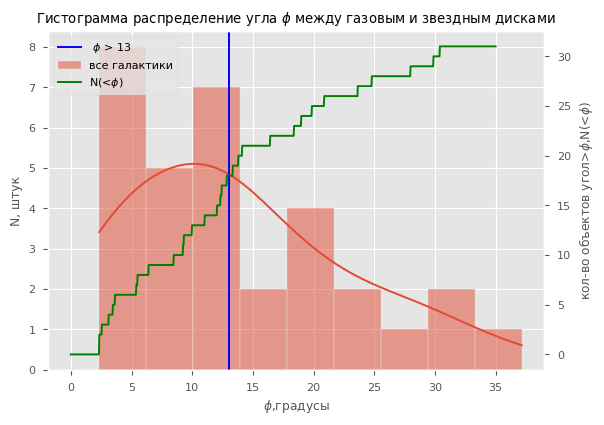

In [715]:
treshoold=13
fig, ax1 = plt.subplots()
sns.histplot(data=res, x="delta+", kde=True,bins=9,label='все галактики',axes=ax1)
ax1.axvline(treshoold,color='blue', label=f' $\phi$ > {treshoold}')
ax1.set_xlabel(r'$\phi$,градусы')
ax1.set_ylabel(r'N, штук')
lines1, labels1 = ax1.get_legend_handles_labels()

less = []
for treshoold in np.linspace(0,35,1000):
    less.append(len(res[res["delta+"]<treshoold]))
ax2 = ax1.twinx()
ax2.plot(np.linspace(0,35,1000),less, color='green',label='N(<$\phi$)')
ax2.grid(False)
ax2.set_ylabel('кол-во объектов угол>$\phi$,N(<$\phi$)')

lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title("Гистограмма распределение угла $\phi$ между газовым и звездным дисками")
plt.savefig('dipimg/Гистограмма распределение угла между газовым и звездным дисками_2')

plt.show()

# Проведем статистический тест

In [26]:
import numpy as np

treshoold=10
KS_ts = []
KS_p = []
KS_len1 = []
KS_len2 = []
for treshoold in np.arange(5,20,1):
    res = mearge_21[mearge_21.log_M>0]
    dist = [distance_to_line_kb(*lint_kb_xy(9, -0.8, 11.5, 1),x, y) for x,y in zip(res.log_M, res.log_sfr)]
    # Пример данных: две выборки по 20 объектов
    sample1 = np.array([d for d,i in zip(dist,res['delta+']) if i <treshoold ])  # Ваши данные
    sample2 = np.array([d for d,i in zip(dist,res['delta+']) if i >= treshoold ])  # Ваши данные

    # Проверка критерием K-S (Колмогорова Смирнова)
    try:
        statistic, p_value = ks_2samp(sample1, sample2)
        
    except:
        continue
    # KS[treshoold]={"p-value":p_value,'len1': len(sample1),'len2': len(sample1)}
    KS_ts.append(treshoold)
    KS_p.append(p_value)
    KS_len1.append(len(sample1))
    KS_len2.append(len(sample2))
    
    # print(f"{treshoold=} {len(sample1)} {len(sample2)}") 
    # print(f"K-S статистика: {statistic:.3f}, p-значение: {p_value:.3f}")
   
    if p_value < 0.05:
        print("Распределения различаются (отвергаем H0)")
    else:
        print("******** Нет доказательств различий (не отвергаем H0)")

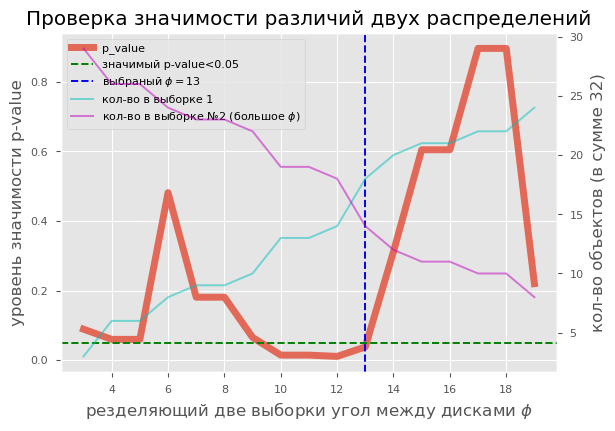

In [53]:
p_value
plt.rcParams['figure.dpi'] = 100
fig, ax1 = plt.subplots()

# plt.plot(KS.keys(),[v for k,v in KS.items()],marker='o')
ax1.plot(KS_ts,KS_p,linewidth = 5, alpha=0.8,label='p_value')#,marker='o'
ax1.axhline(y=0.05, color='g', linestyle='--', label='значимый p-value<0.05')
ax1.axvline(x=13, color='b', linestyle='--', label='выбраный $\phi=13$')
ax1.set_xlabel("резделяющий две выборки угол между дисками $\phi$")
ax1.set_ylabel("уровень значимости p-value")
# ax1.legend()

# Добавляем легенду (объединяем легенды с обеих осей)
lines1, labels1 = ax1.get_legend_handles_labels()


ax2 = plt.twinx()
ax2.plot(KS_ts,KS_len1,color='c',alpha=0.5,label='кол-во в выборке 1')
ax2.plot(KS_ts,KS_len2,color='m',alpha=0.5,label='кол-во в выборке №2 (большое $\phi$)')
ax2.grid(False)
ax2.set_ylabel('кол-во объектов (в сумме 32)')
lines2, labels2 = ax2.get_legend_handles_labels()
plt.title("Проверка значимости различий двух распределений")
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.savefig("dipimg/проверка значимости различий двух распределений")

# Добавим еще одну таблицу

In [29]:

df_beom = pd.read_csv("list_galaxy_from_Beom_v2.csv",delimiter=',')
df_beom.head(-1)

,Unnamed: 0,MaNGAID,PlateifuID,RA,DEC,z,LogM,Reff,G_r,Morp,Type
0,0,1-43773,8140-3702,117.412,42.9671,0.03072,10.73,3.4,0.74,E,CG
1,1,1-174225,8947-1902,170.059,50.0253,0.02601,10.18,1.5,0.71,E,CG
2,2,1-113242,7972-6101,316.709,9.1974,0.04372,11.19,5.4,0.78,E,CG
3,3,1-109392,8085-6101,50.922,?0.1170,0.05148,11.19,6.5,0.78,E,CG
4,4,1-234172,11018-3704,196.517,50.2497,0.04658,11.11,7.2,0.80,E,CG
...,...,...,...,...,...,...,...,...,...,...,...
297,297,1-402422,8330-12702,203.853,38.0951,0.06492,10.77,5.9,0.53,MC,CG
298,298,1-576537,8465-12704,198.142,48.3666,0.05581,10.65,4.6,0.82,MC,CG
299,299,1-24547,9196-1901,261.469,53.5394,0.03005,10.48,1.6,0.77,MC,CG
300,300,1-336458,11960-3701,236.268,8.5597,0.04150,9.97,1.5,0.71,MC,CG


In [30]:
beom_mearge_21 = mearge_21.merge(right=df_beom,how='left',left_on='plateID',right_on='PlateifuID',suffixes=['','_beom'])

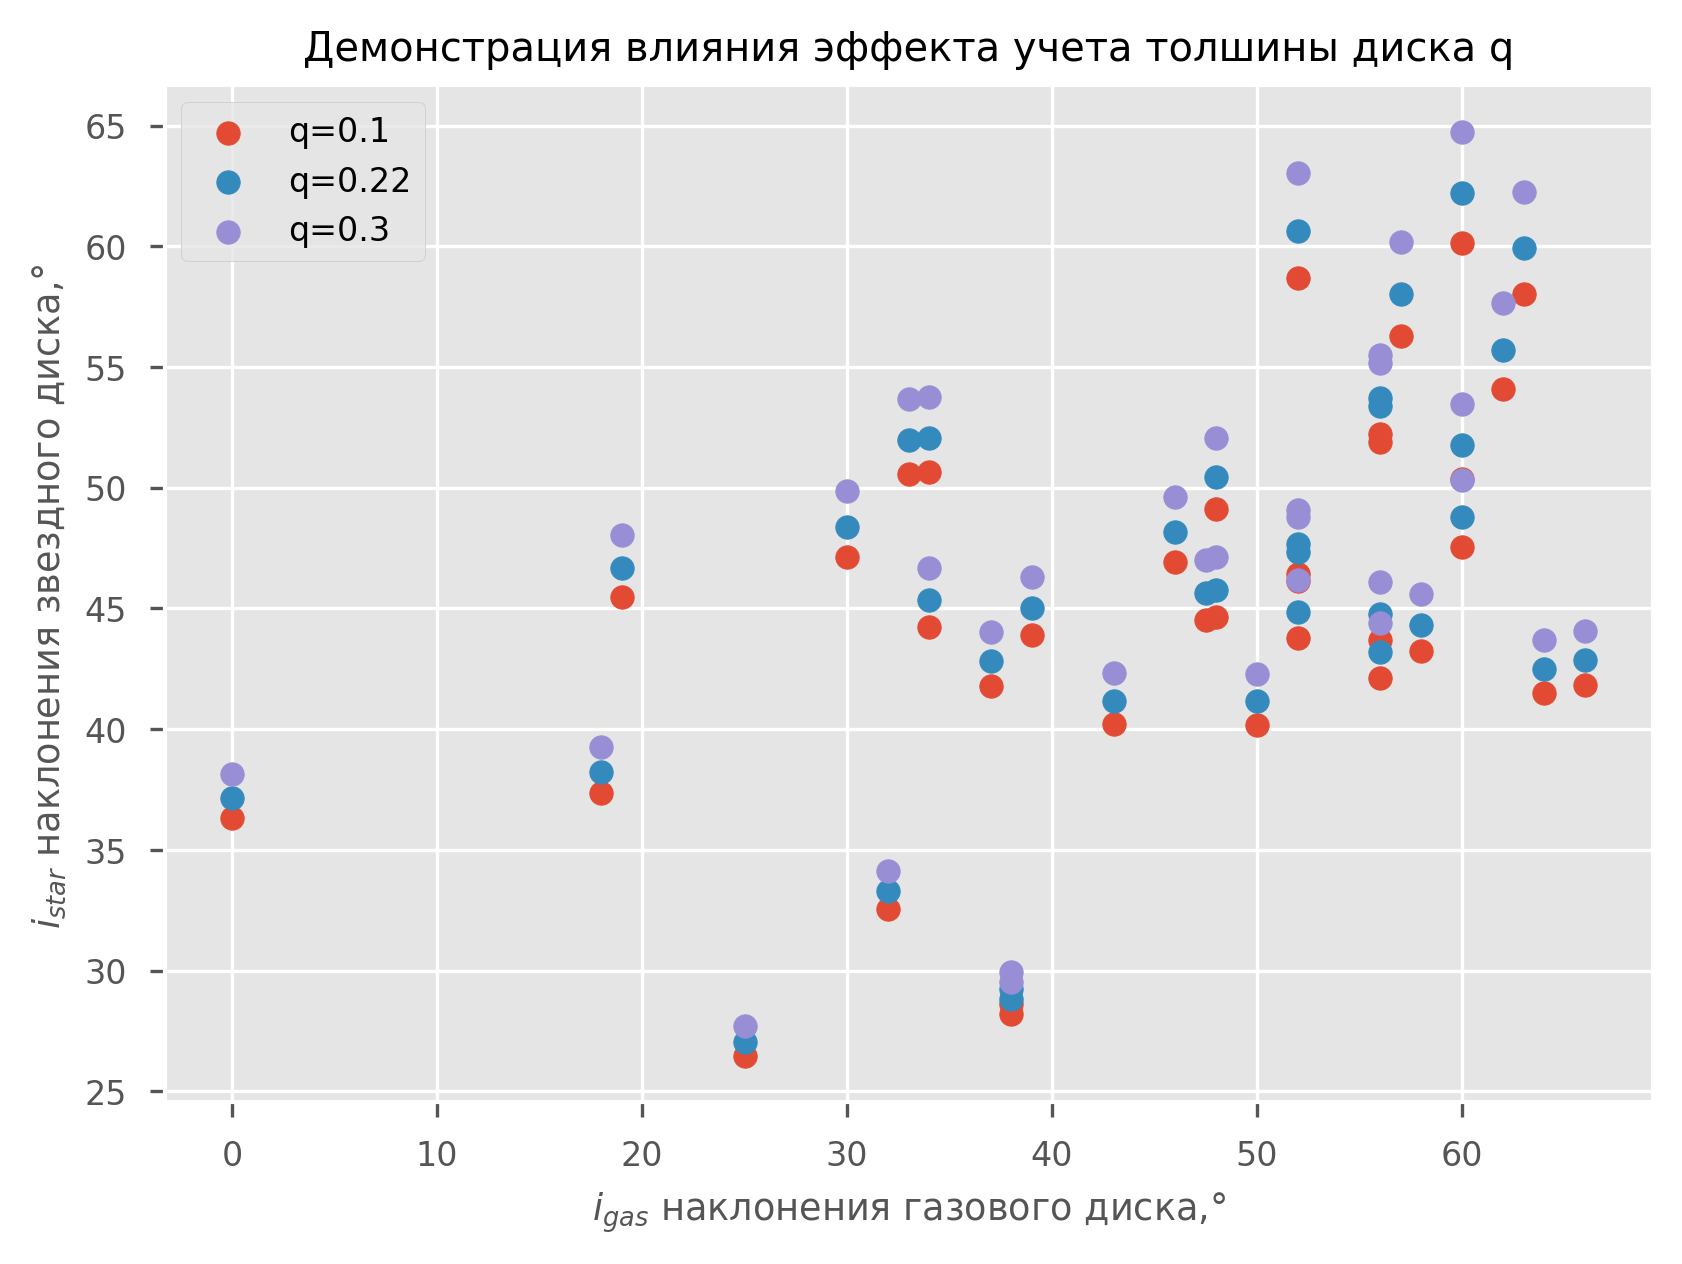

In [399]:
plt.rcParams['figure.dpi'] = 300

plt.scatter(beom_mearge_21['gas_i'],beom_mearge_21['star_i_q1'],label='q=0.1')
plt.scatter(beom_mearge_21['gas_i'],beom_mearge_21['star_i_q22'],label='q=0.22')
plt.scatter(beom_mearge_21['gas_i'],beom_mearge_21['star_i_q3'],label='q=0.3')

plt.xlabel('$i_{gas}$ наклонения газового диска,°')
plt.ylabel('$i_{star}$ наклонения звездного диска,° ')
plt.title('Демонстрация влияния эффекта учета толшины диска q')
plt.legend()

In [33]:
list_table=['IAU Name','plateID','elpetro_phi','gas_phi','star_i_q22', 'gas_i','delta+','log_M', 'log_sfr']
mearge_21[:][list_table].head()

,IAU Name,plateID,elpetro_phi,gas_phi,star_i_q22,gas_i,delta+,log_M,log_sfr
0,NaN,11020-1901,106.7918,108.0,64.257446,64.0,1.117173,0.000,0.000
1,J172238.29+305212.0,7961-6103,64.7916,17.0,42.845290,66.0,44.309507,0.000,0.000
2,J085418.02+263021.9,9506-1902,142.5603,155.0,42.500864,64.0,23.627940,10.006,-1.721
3,J211900.27-005750.2,8615-1902,106.1348,107.0,51.976518,33.0,18.985135,10.161,-0.069
4,J075725.63+272625.3,8149-3703,108.4305,100.0,46.654101,19.0,27.968277,9.721,-0.807


In [545]:
res = mearge_21[mearge_21['gas_i'].notna()]
np.average((res['star_i_q22']-res['gas_i'])),np.std((res['star_i_q22']-res['gas_i']))

(0.5152265894857497, 12.842431073677549)

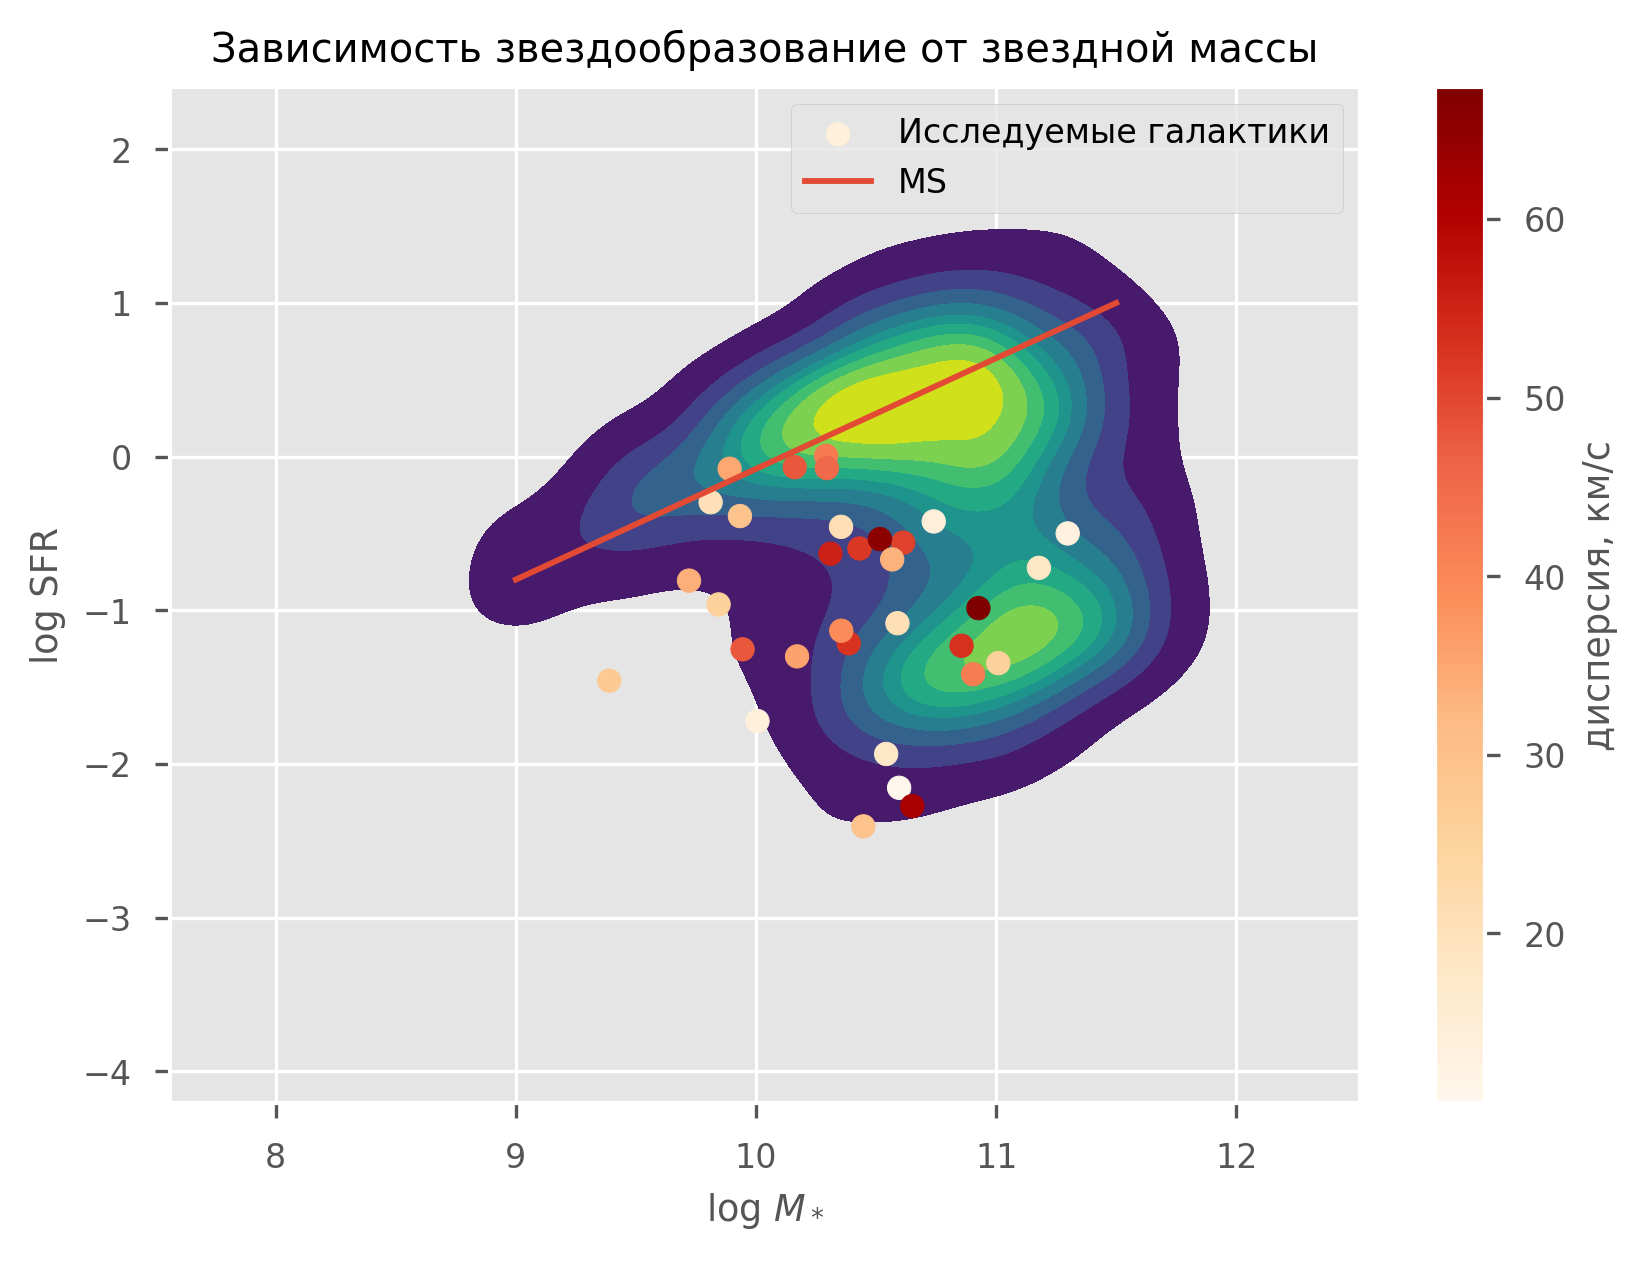

In [645]:
# res[np.random.choice(range(len(D2[D2[9]>0])),100)]
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Включение научного стиля
# plt.style.use('ggplot')
plt.style.use('seaborn-v0_8-paper') 
# plt.set_dpi(300)
plt.rcParams['figure.dpi'] = 300

res = M2[M2[9]>-3][2000:6000]
x,y = res[9], res[11]
sns.kdeplot(x=x, y=y, cmap='viridis', fill=True,)#label = 'галактики из GSWLC-2'
plt.title('Зависимость звездообразование от звездной массы')


res = mearge_21[mearge_21.log_M>0]
# c = res['delta+']
c = res['DISP_med(km/s)']

plt.scatter(res.log_M, res.log_sfr,c=c, cmap='OrRd',label='Исследуемые галактики')
plt.colorbar(label=r'дисперсия, км/с')
plt.xlabel(r'log $M_*$')
plt.ylabel('log SFR')

plt.plot([9,11.5],[-0.8,1],label='MS')
plt.legend()

plt.savefig(r'dipimg/Зависимость звездообразование от звездной массы-.png')
plt.show()

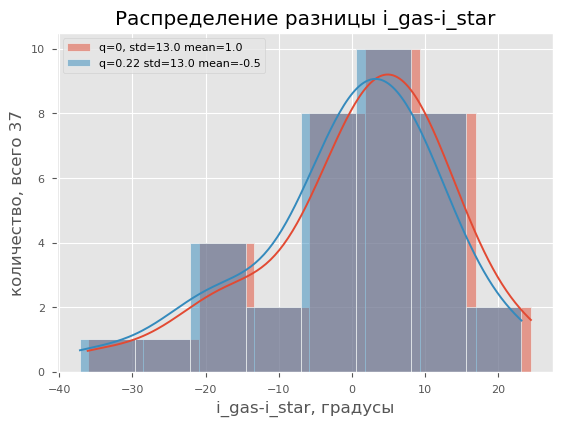

In [118]:
a = (mearge_21.gas_i - mearge_21.star_i)
sns.histplot(a,kde=True, label =f"q=0, std={a.std():2.1f} mean={a.mean():2.1f}")
a = (mearge_21.gas_i - mearge_21.star_i_q22)
sns.histplot(a,kde=True, label =f"q=0.22 std={a.std():2.1f} mean={a.mean():2.1f}")
plt.title("Распределение разницы i_gas-i_star")
plt.xlabel("i_gas-i_star, градусы")
plt.ylabel(f"количество, всего {len(a)}")
# sns.histplot(np.random.normal(loc=0, scale=14, size=1000))
plt.legend()


In [96]:
data = np.random.normal(loc=0, scale=12.9, size=37)
np.std(data)

11.938301316067198

In [67]:
a = (mearge_21.gas_i - mearge_21.star_i_q22)
a.std(),a.mean()

(13.024602315571551, -0.51522658948575)

In [69]:
a = (mearge_21.gas_i - mearge_21.star_i)
a.std(),a.mean()

(13.002141380511091, 0.9846882536265255)

In [117]:
statistic, p_value = ks_2samp((mearge_21.gas_i - mearge_21.star_i_q22), np.random.normal(loc=0, scale=12.9, size=1999))
statistic, p_value

(0.17195084028500737, 0.20705317949374893)